In [1]:

!pip install kaggle

!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d pkdarabi/brain-tumor-image-dataset-semantic-segmentation

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/83.7M [00:00<?, ?B/s]
100% 83.7M/83.7M [00:00<00:00, 1.71GB/s]


In [2]:

!unzip brain-tumor-image-dataset-semantic-segmentation.zip

Archive:  brain-tumor-image-dataset-semantic-segmentation.zip
  inflating: README.txt              
  inflating: test/1030_jpg.rf.4bfc0ebc72d835cb9668219cd911c249.jpg  
  inflating: test/1035_jpg.rf.0dead1ccbe6b1e137ca2d98fc4d34b9a.jpg  
  inflating: test/1056_jpg.rf.f539615badbea313d68c957e76642dda.jpg  
  inflating: test/1058_jpg.rf.f6d6dcde9564c091b30eb6873641ba36.jpg  
  inflating: test/1083_jpg.rf.b1473a76f8f3789c6be693dfbe9bc011.jpg  
  inflating: test/1093_jpg.rf.4cde54a1271fe5ecc1f9d6ca4b00f835.jpg  
  inflating: test/1125_jpg.rf.6a2f54deeac86ff2d961132a828c9ae6.jpg  
  inflating: test/1126_jpg.rf.d216bd33f5b8f7f557d14928c232a377.jpg  
  inflating: test/1130_jpg.rf.d1672624856f1df581acc128aea4a635.jpg  
  inflating: test/1136_jpg.rf.02df64849485272e48139498c36c8e44.jpg  
  inflating: test/1140_jpg.rf.f8a48ff0879568ff23cd511711ef650e.jpg  
  inflating: test/1151_jpg.rf.17b666e0803c2fcd6b5b292fadf7afd5.jpg  
  inflating: test/1174_jpg.rf.336d0729fe53adf926746fe2fe9cd0df.jpg  
  i

In [3]:
# Estructura del DF
import json

def print_structure (d, indent=0):
    if isinstance(d,dict):
        for key , value in d.items():
            print(' ' * indent + str(key))
            print_structure(value,indent+1)
    elif isinstance(d, list):
        print(' ' * indent + "list of length {} containing : ".format(len(d)))
        if d:
            print_structure(d[0],indent+1)

with open('/content/valid/_annotations.coco.json','r') as file:
    data = json.load(file)

print_structure(data)

info
 year
 version
 description
 contributor
 url
 date_created
licenses
 list of length 1 containing : 
  id
  url
  name
categories
 list of length 3 containing : 
  id
  name
  supercategory
images
 list of length 429 containing : 
  id
  license
  file_name
  height
  width
  date_captured
annotations
 list of length 429 containing : 
  id
  image_id
  category_id
  bbox
   list of length 4 containing : 
  area
  segmentation
   list of length 1 containing : 
    list of length 10 containing : 
  iscrowd


In [4]:
from pycocotools.coco import COCO

In [5]:
train_dir = '/content/train'
val_dir = '/content/valid'
test_dir = '/content/test'

train_annotation_file = '/content/train/_annotations.coco.json'
test_annotation_file = '/content/test/_annotations.coco.json'
val_annotation_file = '/content/valid/_annotations.coco.json'

In [6]:
train_coco = COCO(train_annotation_file)
val_coco = COCO(val_annotation_file)
test_coco = COCO(test_annotation_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Pipeline de preprocesamiento

In [7]:
import os
from PIL import Image
import numpy as np
from pycocotools.coco import COCO

def load_image_and_mask(coco, image_dir, image_id):
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(image_dir, image_info['file_name'])
    image = Image.open(image_path)
    image = np.array(image)

    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((image_info['height'], image_info['width']))
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    return image, mask

In [8]:

img_ids = train_coco.getImgIds()

for i, img_id in enumerate(img_ids[:1]):

    img_info = train_coco.loadImgs(img_id)[0]

    filename = img_info['file_name']
    height = img_info['height']
    width = img_info['width']

    print(f"Archivo: {filename}, Dimensiones: {height}x{width}")

Archivo: 2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg, Dimensiones: 640x640


# Metricas

In [52]:
import tensorflow as tf
import tensorflow.keras.backend as K

# --- Métrica de Coeficiente de Dice (para monitoreo) ---
def dice_coef(y_true, y_pred, smooth=100):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    return (2. * intersection + smooth) / (union + smooth)

# --- Pérdida Tversky (Penaliza FN) ---
def tversky_loss(y_true, y_pred, smooth=1e-6, alpha=0.3, beta=0.7):
    y_true_pos = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_pos = K.flatten(y_pred)

    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)

    numerator = true_pos + smooth
    denominator = true_pos + alpha * false_pos + beta * false_neg + smooth
    return 1 - (numerator / denominator)

# --- Pérdida Focal Binaria (Maneja píxeles difíciles) ---
def binary_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(y_pred)

    bce = K.binary_crossentropy(y_true_f, y_pred_f)

    p_t = (y_true_f * y_pred_f) + ((1 - y_true_f) * (1 - y_pred_f))
    alpha_factor = (y_true_f * alpha) + ((1 - y_true_f) * (1 - alpha))
    modulating_factor = K.pow(1.0 - p_t, gamma)

    return K.mean(alpha_factor * modulating_factor * bce)

# --- Pérdida Combinada ---
def combined_loss(y_true, y_pred, tversky_weight=0.6, focal_weight=0.4):
    t_loss = tversky_loss(y_true, y_pred)
    f_loss = binary_focal_loss(y_true, y_pred)
    return (tversky_weight * t_loss) + (focal_weight * f_loss)

# Aumentacion de Datos

In [10]:
!pip install albumentations==1.4.3 opencv-python-headless==4.10.0.84


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8


In [35]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from pycocotools.coco import COCO
import albumentations as A
import cv2

augment = A.Compose([
    A.ElasticTransform(alpha=50, sigma=5, alpha_affine=5, p=0.5),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3)
])

In [56]:

def patch_generator(coco, image_dir, image_ids, patch_size=(256, 256),
                    patches_per_image=10, tumor_ratio=0.8, hard_negative_std_thresh=25,
                    infinite_loop=True): # <<< NUEVO ARGUMENTO

    H, W = patch_size
    TARGET_SIZE = (512, 512)
    FULL_H, FULL_W = TARGET_SIZE

    def load_full_image_and_mask(image_id):
        # ... (esta función interna no cambia) ...
        image_info = coco.loadImgs(image_id)[0]
        image_path = os.path.join(image_dir, image_info['file_name'])
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)

        ann_ids = coco.getAnnIds(imgIds=image_id)
        anns = coco.loadAnns(ann_ids)
        mask = np.zeros((image_info['height'], image_info['width']))
        for ann in anns:
            mask = np.maximum(mask, coco.annToMask(ann))

        image_resized = cv2.resize(image, TARGET_SIZE, interpolation=cv2.INTER_LINEAR).astype(np.uint8)
        mask_resized = cv2.resize(mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST).astype(np.uint8)
        mask_resized = mask_resized[..., np.newaxis]

        return image_resized, mask_resized

    # --- CORRECCIÓN DEL BUG (Bucle Infinito) ---
    while True:
        np.random.shuffle(image_ids)

        for image_id in image_ids:
            image_full, mask_full = load_full_image_and_mask(image_id)

            patches_generated = 0
            attempts = 0

            while patches_generated < patches_per_image and attempts < 100:
                attempts += 1

                x, y = 0, 0
                if (FULL_W - W) > 0:
                    x = np.random.randint(0, FULL_W - W)
                if (FULL_H - H) > 0:
                    y = np.random.randint(0, FULL_H - H)

                patch_img = image_full[y:y+H, x:x+W]
                patch_mask = mask_full[y:y+H, x:x+W]

                has_tumor = np.sum(patch_mask) > 0
                is_background_sample = np.random.rand() > tumor_ratio
                is_hard_negative = np.std(patch_img) > hard_negative_std_thresh

                if has_tumor or (is_background_sample and is_hard_negative):

                    if (H, W) == TARGET_SIZE:
                        aug_img = patch_img
                        aug_mask = patch_mask.squeeze()
                    else:
                        augmented = augment(image=patch_img, mask=patch_mask.squeeze())
                        aug_img = augmented['image']
                        aug_mask = augmented['mask']

                    aug_img = aug_img.astype(np.float32) / 255.0
                    aug_mask = aug_mask.astype(np.uint8)[..., np.newaxis]

                    yield aug_img, aug_mask
                    patches_generated += 1

        if not infinite_loop:
            break # <<< Sale del 'while True' si el generador no debe ser infinito
    # --- FIN DE LA CORRECCIÓN ---


# --- Creación de los Datasets (V4) ---
PATCH_SIZE = (256, 256)
BATCH_SIZE = 16

train_ids = train_coco.getImgIds()
val_ids = val_coco.getImgIds()
test_ids = test_coco.getImgIds()

output_sig = (
    tf.TensorSpec(shape=(*PATCH_SIZE, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(*PATCH_SIZE, 1), dtype=tf.uint8)
)

# train y val siguen siendo infinitos (infinite_loop=True por defecto)
train_dataset = tf.data.Dataset.from_generator(
    lambda: patch_generator(train_coco, train_dir, train_ids, patch_size=PATCH_SIZE, tumor_ratio=0.7, patches_per_image=10),
    output_signature=output_sig
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: patch_generator(val_coco, val_dir, val_ids, patch_size=PATCH_SIZE, tumor_ratio=0.5, patches_per_image=4),
    output_signature=output_sig
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# test_dataset_full AHORA ES FINITO
test_dataset_full = tf.data.Dataset.from_generator(
    lambda: patch_generator(test_coco, test_dir, test_ids, patch_size=(512,512),
                            tumor_ratio=1.0, patches_per_image=1, hard_negative_std_thresh=-1,
                            infinite_loop=False), # <<< SE PASA EL NUEVO ARGUMENTO
    output_signature=(
        tf.TensorSpec(shape=(512, 512, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(512, 512, 1), dtype=tf.uint8)
    )
).prefetch(tf.data.AUTOTUNE)

In [37]:
def augment_data(image, mask):
    def _augment(image_np, mask_np):
        image_np = image_np.numpy()
        mask_np = mask_np.numpy()

        augmented = augment(image=image_np, mask=mask_np)
        return augmented['image'], augmented['mask']

    image, mask = tf.py_function(
        func=_augment,
        inp=[image, mask],
        Tout=[tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8), tf.TensorSpec(shape=(None, None), dtype=tf.uint8)] #
    )

    image.set_shape([None, None, 3])
    mask.set_shape([None, None])
    return image, mask

# Modelo

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, concatenate
from tensorflow.keras.layers import ReLU, BatchNormalization, Activation, Input, Add, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.layers import DepthwiseConv2D

In [39]:
# Bloque de Convolución Profundamente Separable

def ds_block(x, filters, kernel_size=(3, 3), padding="same"):
    # 1. Convolución Profunda (Depthwise)
    # Usa DepthwiseConv2D.
    x = DepthwiseConv2D(kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 2. Convolución Puntual
    # Usa Conv2D con un kernel de 1x1. Es la que define el número final de 'filters'.
    x = Conv2D(filters, (1, 1), padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [40]:
# Bloque de Atención

def attention_gate(g, x, filters):
    # g: señal del Decodificador
    # x: señal del Codificador (skip connection)

    # 1. Proyectar g y x al mismo espacio de baja dimensión
    g_conv = Conv2D(filters, (1, 1), padding='same')(g)
    x_conv = Conv2D(filters, (1, 1), padding='same')(x)

    # 2. Sumar y aplicar ReLU
    sum_relu = ReLU()(Add()([g_conv, x_conv]))

    # 3. Mapear la atencion
    psi = Conv2D(1, (1, 1), padding='same')(sum_relu)
    attention_map = Activation('sigmoid')(psi)

    # 4. Multiplicar el mapa de atención por la señal de entrada (x)
    return Multiply()([x, attention_map])


In [41]:
# Ensamblaje de la Attn-DS-UNet

def attn_ds_unet(input_shape, num_classes=1, start_filters=32):

    inputs = Input(input_shape)

    #  CODIFICADOR (contraccion)
    # Nivel 0
    c0 = Conv2D(start_filters, (3, 3), padding='same', activation='relu')(inputs)
    c0 = ds_block(c0, start_filters)

    # Nivel 1
    c1 = MaxPool2D((2, 2))(c0)
    c1 = ds_block(c1, start_filters * 2)

    # Nivel 2
    c2 = MaxPool2D((2, 2))(c1)
    c2 = ds_block(c2, start_filters * 4)

    # Nivel 3
    c3 = MaxPool2D((2, 2))(c2)
    c3 = ds_block(c3, start_filters * 8)

    #  BOTTLENECK
    b = MaxPool2D((2, 2))(c3)
    b = ds_block(b, start_filters * 16)

    #  DECODIFICADOR (Expansión)
    # Nivel 3 (Expansión)
    u3 = Conv2DTranspose(start_filters * 8, (2, 2), strides=(2, 2), padding='same')(b)
    a3 = attention_gate(u3, c3, start_filters * 8) # Aplicar Atención
    u3 = concatenate([u3, a3])
    u3 = ds_block(u3, start_filters * 8)

    # Nivel 2 (Expansión)
    u2 = Conv2DTranspose(start_filters * 4, (2, 2), strides=(2, 2), padding='same')(u3)
    a2 = attention_gate(u2, c2, start_filters * 4) # Aplicar Atención
    u2 = concatenate([u2, a2])
    u2 = ds_block(u2, start_filters * 4)

    # Nivel 1 (Expansión)
    u1 = Conv2DTranspose(start_filters * 2, (2, 2), strides=(2, 2), padding='same')(u2)
    a1 = attention_gate(u1, c1, start_filters * 2) # Aplicar Atención
    u1 = concatenate([u1, a1])
    u1 = ds_block(u1, start_filters * 2)

    # Nivel 0 (Expansión)
    u0 = Conv2DTranspose(start_filters, (2, 2), strides=(2, 2), padding='same')(u1)
    a0 = attention_gate(u0, c0, start_filters) # Aplicar Atención
    u0 = concatenate([u0, a0])
    u0 = ds_block(u0, start_filters)

    #  CAPA DE SALIDA
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid', dtype='float32')(u0)

    return Model(inputs=inputs, outputs=outputs)



In [42]:
input_size = (*PATCH_SIZE, 3)
model = attn_ds_unet(input_size, start_filters=32)

In [43]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 256, 256,  │        896 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_45 │ (None, 256, 256,  │        320 │ conv2d_115[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_110      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 256, 256,  │      1,056 │ activation_110[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_116[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_111      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 128, 128,  │          0 │ activation_111[0… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_46 │ (None, 128, 128,  │        320 │ max_pooling2d_20… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_112      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 128, 128,  │      2,112 │ activation_112[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_117[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_113      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 64, 64,    │          0 │ activation_113[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_47 │ (None, 64, 64,    │        640 │ max_pooling2d_21

 Total params: 1,250,405 (4.77 MB)

 Trainable params: 1,244,517 (4.75 MB)

 Non-trainable params: 5,888 (23.00 KB)

# Entrenamiento

In [44]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Política actual:", mixed_precision.global_policy())


Política actual: <DTypePolicy "mixed_float16">


In [45]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Compilación del modelo (V4)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=[dice_coef]
)

# Callbacks
checkpoint = ModelCheckpoint(
    'best_model_v4.h5', # Nuevo archivo de pesos
    monitor='val_dice_coef',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_dice_coef',
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_dice_coef',
    factor=0.5,
    patience=5,
    mode='max',
    min_lr=1e-6,
    verbose=1
)


In [46]:
print("Cargando pesos de la Época 5...")
model.load_weights('best_model_v4.h5')

steps_per_epoch = len(train_ids) * 10 // BATCH_SIZE
validation_steps = len(val_ids) * 4 // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    initial_epoch=5,  # <<< Indicar que se reanuda desde la época 5
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Cargando pesos de la Época 5...
Epoch 6/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - dice_coef: 0.4902 - loss: 0.3246
Epoch 6: val_dice_coef improved from -inf to 0.48280, saving model to best_model_v4.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 273s 247ms/step - dice_coef: 0.4902 - loss: 0.3246 - val_dice_coef: 0.4828 - val_loss: 0.3373 - learning_rate: 1.0000e-04
Epoch 7/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - dice_coef: 0.5131 - loss: 0.3103
Epoch 7: val_dice_coef improved from 0.48280 to 0.50202, saving model to best_model_v4.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 226s 241ms/step - dice_coef: 0.5131 - loss: 0.3103 - val_dice_coef: 0.5020 - val_loss: 0.3232 - learning_rate: 1.0000e-04
Epoch 8/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - dice_coef: 0.5196 - loss: 0.3065
Epoch 8: val_dice_coef did not improve from 0.50202
938/938 ━━━━━━━━━━━━━━━━━━━━ 227s 242ms/step - dice_coef: 0.5196 - loss: 0.3065 - val_dice_coef: 0.4842 - val_loss: 0.3357 - learning_rate: 1.0000e-04
Epoch 9/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - dice_coef: 0.5371 - loss: 0.2981
Epoch 9: val_dice_coef did not improve from 0.50202
938/938 ━━━━━━━━━━━━━━━━━━━━ 225s 240ms/step - dice_coef: 0.5371 - loss: 0.2981 - val_dice_coef: 0.4951 - val_loss: 0.3317 - learning_rate: 1.0000e-04
Epoch 10/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - dice_coef: 0.5502 - loss: 0.2894
Epoch 10: val_dice_coef improved from 0.50202 to 0.50705, saving model to best_model_v4.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 225s 239ms/step - dice_coef: 0.5502 - loss: 0.2894 - val_dice_coef: 0.5071 - val_loss: 0.3156 - learning_rate: 1.0000e-04
Epoch 11/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - dice_coef: 0.5426 - loss: 0.2936
Epoch 11: val_dice_coef improved from 0.50705 to 0.51669, saving model to best_model_v4.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 229s 244ms/step - dice_coef: 0.5426 - loss: 0.2936 - val_dice_coef: 0.5167 - val_loss: 0.3116 - learning_rate: 1.0000e-04
Epoch 12/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - dice_coef: 0.5415 - loss: 0.2930
Epoch 12: val_dice_coef improved from 0.51669 to 0.51987, saving model to best_model_v4.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 232s 248ms/step - dice_coef: 0.5415 - loss: 0.2930 - val_dice_coef: 0.5199 - val_loss: 0.3220 - learning_rate: 1.0000e-04
Epoch 13/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coef: 0.5618 - loss: 0.2821
Epoch 13: val_dice_coef did not improve from 0.51987
938/938 ━━━━━━━━━━━━━━━━━━━━ 218s 232ms/step - dice_coef: 0.5618 - loss: 0.2821 - val_dice_coef: 0.4979 - val_loss: 0.3209 - learning_rate: 1.0000e-04
Epoch 14/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coef: 0.5545 - loss: 0.2872
Epoch 14: val_dice_coef improved from 0.51987 to 0.52803, saving model to best_model_v4.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 219s 234ms/step - dice_coef: 0.5545 - loss: 0.2872 - val_dice_coef: 0.5280 - val_loss: 0.3241 - learning_rate: 1.0000e-04
Epoch 15/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coef: 0.5573 - loss: 0.2843
Epoch 15: val_dice_coef improved from 0.52803 to 0.54926, saving model to best_model_v4.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 220s 234ms/step - dice_coef: 0.5573 - loss: 0.2843 - val_dice_coef: 0.5493 - val_loss: 0.2994 - learning_rate: 1.0000e-04
Epoch 16/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - dice_coef: 0.5847 - loss: 0.2673
Epoch 16: val_dice_coef did not improve from 0.54926
938/938 ━━━━━━━━━━━━━━━━━━━━ 216s 230ms/step - dice_coef: 0.5847 - loss: 0.2673 - val_dice_coef: 0.5168 - val_loss: 0.3217 - learning_rate: 1.0000e-04
Epoch 17/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coef: 0.5760 - loss: 0.2725
Epoch 17: val_dice_coef did not improve from 0.54926
938/938 ━━━━━━━━━━━━━━━━━━━━ 218s 232ms/step - dice_coef: 0.5760 - loss: 0.2725 - val_dice_coef: 0.5222 - val_loss: 0.3263 - learning_rate: 1.0000e-04
Epoch 18/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coef: 0.5819 - loss: 0.2688
Epoch 18: val_dice_coef did not improve from 0.54926
938/938 ━━━━━━━━━━━━━━━━━━━━ 217s 232ms/step - dice_coef: 0.5819 - loss: 0.2688 - val_dice_coef: 0.5369 - val_loss: 0.

938/938 ━━━━━━━━━━━━━━━━━━━━ 220s 234ms/step - dice_coef: 0.5964 - loss: 0.2597 - val_dice_coef: 0.5736 - val_loss: 0.2792 - learning_rate: 5.0000e-05
Epoch 22/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coef: 0.6093 - loss: 0.2526
Epoch 22: val_dice_coef did not improve from 0.57359
938/938 ━━━━━━━━━━━━━━━━━━━━ 217s 232ms/step - dice_coef: 0.6093 - loss: 0.2526 - val_dice_coef: 0.5685 - val_loss: 0.2844 - learning_rate: 5.0000e-05
Epoch 23/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coef: 0.5898 - loss: 0.2639
Epoch 23: val_dice_coef improved from 0.57359 to 0.58344, saving model to best_model_v4.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 218s 233ms/step - dice_coef: 0.5899 - loss: 0.2639 - val_dice_coef: 0.5834 - val_loss: 0.2835 - learning_rate: 5.0000e-05
Epoch 24/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - dice_coef: 0.6183 - loss: 0.2472
Epoch 24: val_dice_coef did not improve from 0.58344
938/938 ━━━━━━━━━━━━━━━━━━━━ 216s 230ms/step - dice_coef: 0.6183 - loss: 0.2473 - val_dice_coef: 0.5680 - val_loss: 0.2866 - learning_rate: 5.0000e-05
Epoch 25/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coef: 0.6076 - loss: 0.2527
Epoch 25: val_dice_coef improved from 0.58344 to 0.58446, saving model to best_model_v4.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 218s 233ms/step - dice_coef: 0.6077 - loss: 0.2527 - val_dice_coef: 0.5845 - val_loss: 0.2827 - learning_rate: 5.0000e-05
Epoch 26/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - dice_coef: 0.6087 - loss: 0.2531
Epoch 26: val_dice_coef improved from 0.58446 to 0.58603, saving model to best_model_v4.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 216s 230ms/step - dice_coef: 0.6087 - loss: 0.2531 - val_dice_coef: 0.5860 - val_loss: 0.2792 - learning_rate: 5.0000e-05
Epoch 27/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coef: 0.6196 - loss: 0.2459
Epoch 27: val_dice_coef improved from 0.58603 to 0.58873, saving model to best_model_v4.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 220s 234ms/step - dice_coef: 0.6196 - loss: 0.2459 - val_dice_coef: 0.5887 - val_loss: 0.2768 - learning_rate: 5.0000e-05
Epoch 28/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coef: 0.6144 - loss: 0.2493
Epoch 28: val_dice_coef did not improve from 0.58873
938/938 ━━━━━━━━━━━━━━━━━━━━ 217s 232ms/step - dice_coef: 0.6144 - loss: 0.2493 - val_dice_coef: 0.5649 - val_loss: 0.2886 - learning_rate: 5.0000e-05
Epoch 29/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - dice_coef: 0.6231 - loss: 0.2418
Epoch 29: val_dice_coef did not improve from 0.58873
938/938 ━━━━━━━━━━━━━━━━━━━━ 219s 234ms/step - dice_coef: 0.6231 - loss: 0.2418 - val_dice_coef: 0.5838 - val_loss: 0.2747 - learning_rate: 5.0000e-05
Epoch 30/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - dice_coef: 0.6134 - loss: 0.2508
Epoch 30: val_dice_coef did not improve from 0.58873
938/938 ━━━━━━━━━━━━━━━━━━━━ 216s 231ms/step - dice_coef: 0.6134 - loss: 0.2508 - val_dice_coef: 0.5734 - val_loss: 0.

938/938 ━━━━━━━━━━━━━━━━━━━━ 220s 234ms/step - dice_coef: 0.6222 - loss: 0.2440 - val_dice_coef: 0.5915 - val_loss: 0.2764 - learning_rate: 5.0000e-05
Epoch 32/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - dice_coef: 0.6188 - loss: 0.2466
Epoch 32: val_dice_coef did not improve from 0.59148
938/938 ━━━━━━━━━━━━━━━━━━━━ 214s 228ms/step - dice_coef: 0.6188 - loss: 0.2466 - val_dice_coef: 0.5895 - val_loss: 0.2701 - learning_rate: 5.0000e-05
Epoch 33/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - dice_coef: 0.6209 - loss: 0.2444
Epoch 33: val_dice_coef did not improve from 0.59148
938/938 ━━━━━━━━━━━━━━━━━━━━ 250s 267ms/step - dice_coef: 0.6209 - loss: 0.2444 - val_dice_coef: 0.5871 - val_loss: 0.2800 - learning_rate: 5.0000e-05
Epoch 34/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - dice_coef: 0.6107 - loss: 0.2518
Epoch 34: val_dice_coef did not improve from 0.59148
938/938 ━━━━━━━━━━━━━━━━━━━━ 217s 231ms/step - dice_coef: 0.6107 - loss: 0.2518 - val_dice_coef: 0.5762 - val_loss: 0.

938/938 ━━━━━━━━━━━━━━━━━━━━ 219s 233ms/step - dice_coef: 0.6345 - loss: 0.2368 - val_dice_coef: 0.6029 - val_loss: 0.2659 - learning_rate: 2.5000e-05
Epoch 38/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - dice_coef: 0.6370 - loss: 0.2354
Epoch 38: val_dice_coef did not improve from 0.60290
938/938 ━━━━━━━━━━━━━━━━━━━━ 218s 233ms/step - dice_coef: 0.6370 - loss: 0.2354 - val_dice_coef: 0.5986 - val_loss: 0.2662 - learning_rate: 2.5000e-05
Epoch 39/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - dice_coef: 0.6263 - loss: 0.2408
Epoch 39: val_dice_coef did not improve from 0.60290
938/938 ━━━━━━━━━━━━━━━━━━━━ 221s 236ms/step - dice_coef: 0.6263 - loss: 0.2408 - val_dice_coef: 0.5959 - val_loss: 0.2719 - learning_rate: 2.5000e-05
Epoch 40/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - dice_coef: 0.6353 - loss: 0.2360
Epoch 40: val_dice_coef improved from 0.60290 to 0.60531, saving model to best_model_v4.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 219s 233ms/step - dice_coef: 0.6353 - loss: 0.2360 - val_dice_coef: 0.6053 - val_loss: 0.2624 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 40.


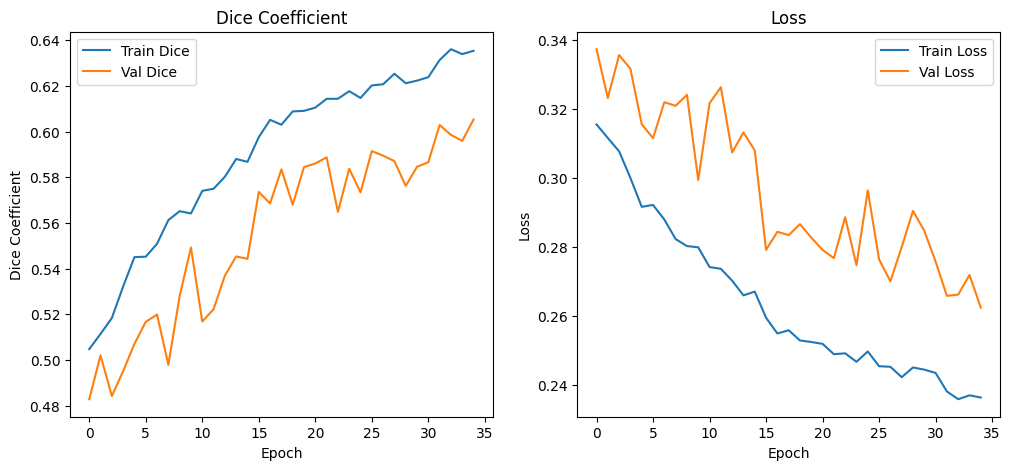

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.title('Dice Coefficient')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()



Iniciando evaluación V4 (Ventana Deslizante + TTA + Post-Procesamiento)...


  0%|          | 0/215 [00:00<?, ?it/s]


--- Resultados Finales (V4) ---
Test Dice Coefficient (Evaluación Completa): 0.6305

Visualizando predicciones finales...


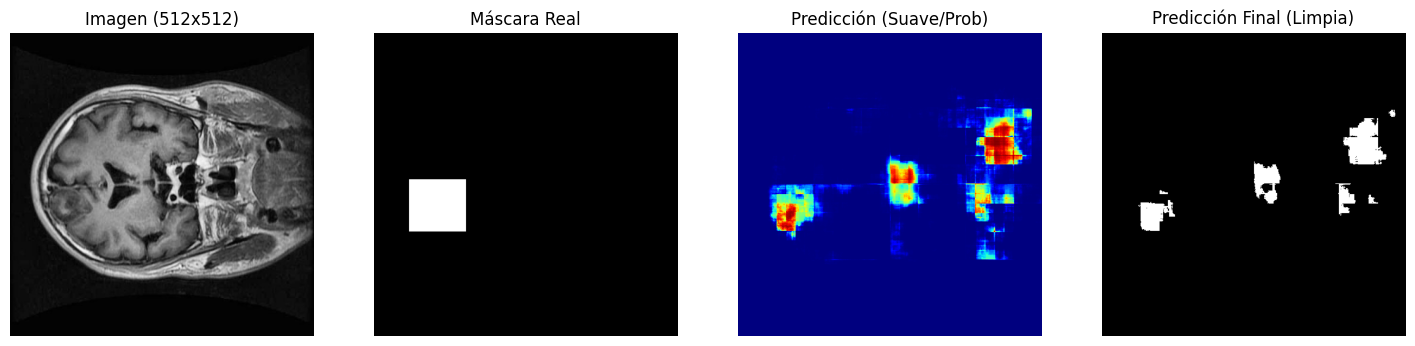

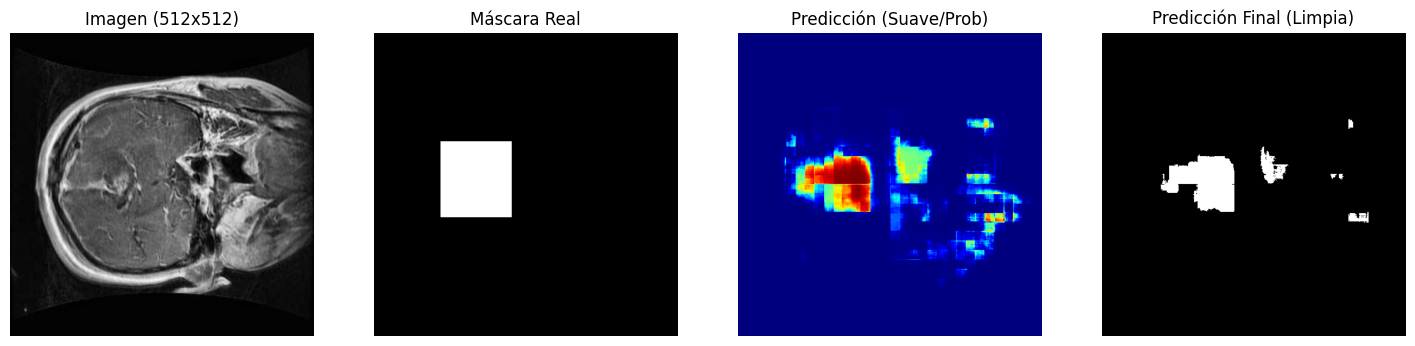

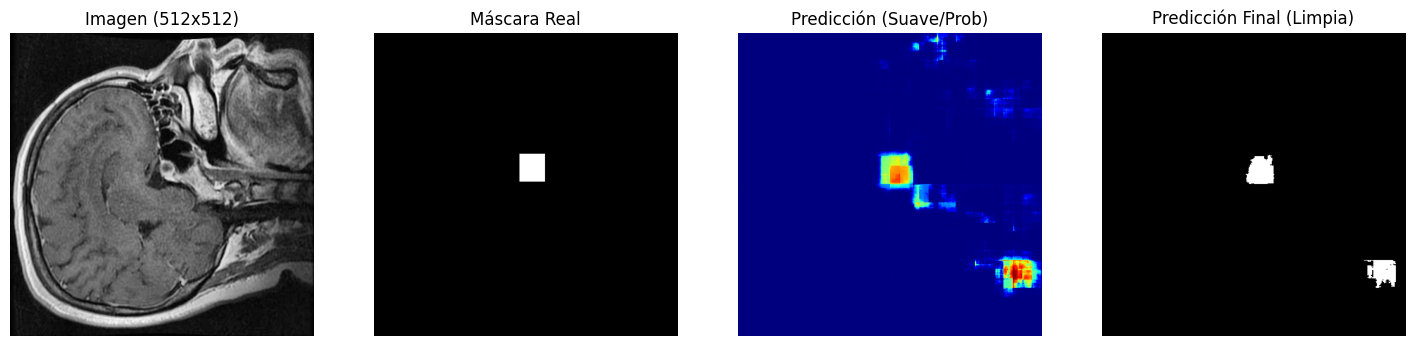

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

# --- Función de limpieza de ruido (Post-procesamiento) ---
def clean_noise(mask, min_area=20):
    mask_uint8 = (mask * 255).astype(np.uint8).squeeze()
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_uint8, 4, cv2.CV_32S)

    cleaned_mask = np.zeros_like(mask_uint8)
    if num_labels > 1:
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= min_area:
                cleaned_mask[labels == i] = 1

    return np.expand_dims(cleaned_mask.astype(np.uint8), axis=-1)

# --- Inferencia de Ventana Deslizante con TTA ---
def sliding_window_inference(model, image_512, patch_size=(256, 256), stride=128, tta=True):
    H, W, C = image_512.shape
    PS_H, PS_W = patch_size

    # Acumuladores para promediar predicciones solapadas
    pred_accumulator = np.zeros((H, W, 1), dtype=np.float32)
    count_accumulator = np.zeros((H, W, 1), dtype=np.float32)

    for y in range(0, H - PS_H + 1, stride):
        for x in range(0, W - PS_W + 1, stride):
            patch = image_512[y:y+PS_H, x:x+PS_W, :]
            patch_input = np.expand_dims(patch, axis=0)

            # Predicción base
            pred = model.predict(patch_input, verbose=0)[0]

            if tta:
                # TTA: Flip horizontal
                patch_flipped = np.fliplr(patch)
                patch_flipped_input = np.expand_dims(patch_flipped, axis=0)
                pred_flipped = model.predict(patch_flipped_input, verbose=0)[0]
                # Revertir flip y promediar
                pred = (pred + np.fliplr(pred_flipped)) / 2.0

            pred_accumulator[y:y+PS_H, x:x+PS_W, :] += pred
            count_accumulator[y:y+PS_H, x:x+PS_W, :] += 1

    # Evitar división por cero
    count_accumulator[count_accumulator == 0] = 1.0
    final_prediction_mask = pred_accumulator / count_accumulator
    return final_prediction_mask

# --- Bucle de Evaluación (V4) ---
print("\nIniciando evaluación V4 (Ventana Deslizante + TTA + Post-Procesamiento)...")

# Recargar el mejor modelo guardado
model.load_weights('best_model_v4.h5')

all_dice_scores = []

# Iterar sobre el dataset de prueba (imágenes completas)
for img_full, mask_true in tqdm(test_dataset_full, total=len(test_ids)):
    # img_full y mask_true ya tienen shape (512, 512, C)

    # 1. Inferencia por Ventana Deslizante
    # (El generador ya normaliza la imagen)
    mask_pred_smooth = sliding_window_inference(model, img_full.numpy(), patch_size=PATCH_SIZE, stride=128, tta=True)

    # 2. Umbral
    mask_pred_binary = (mask_pred_smooth > 0.5).astype(np.uint8)

    # 3. Post-procesamiento (Limpieza de ruido)
    mask_pred_cleaned = clean_noise(mask_pred_binary, min_area=50)

    # 4. Calcular métrica
    score = dice_coef(mask_true.numpy(), mask_pred_cleaned)
    all_dice_scores.append(score)

print(f"\n--- Resultados Finales (V4) ---")
print(f"Test Dice Coefficient (Evaluación Completa): {np.mean(all_dice_scores):.4f}")

# --- Visualización Final ---
print("\nVisualizando predicciones finales...")

for img_full, mask_true in test_dataset_full.take(3):
    mask_pred_smooth = sliding_window_inference(model, img_full.numpy(), patch_size=PATCH_SIZE, stride=128, tta=True)
    mask_pred_binary = (mask_pred_smooth > 0.5).astype(np.uint8)
    mask_pred_cleaned = clean_noise(mask_pred_binary, min_area=50)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img_full)
    plt.title("Imagen (512x512)")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(mask_true.numpy().squeeze(), cmap="gray")
    plt.title("Máscara Real")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(mask_pred_smooth.squeeze(), cmap="jet")
    plt.title("Predicción (Suave/Prob)")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(mask_pred_cleaned.squeeze(), cmap="gray")
    plt.title("Predicción Final (Limpia)")
    plt.axis("off")

    plt.show()